In [ ]:
import pandas as pd


df = pd.read_csv("edos_data.csv")

sexist_data = df[df['label_sexist'] == 'sexist']

train_sexist = sexist_data[sexist_data['split'] == 'train']
dev_sexist = sexist_data[sexist_data['split'] == 'dev']
test_sexist = sexist_data[sexist_data['split'] == 'test']

train_sexist.to_csv("train_sexist.csv", index=False)
dev_sexist.to_csv("dev_sexist.csv", index=False)
test_sexist.to_csv("test_sexist.csv", index=False)


In [ ]:
from nltk.corpus import wordnet

def find_synonyms(word):
    synonyms = []
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonyms.append(lemma.name())
    return synonyms

word = "bitch"
synonyms = find_synonyms(word)
print("Synonyms of '{}' are:".format(word))
print(synonyms)


Synonyms of 'bitch' are:
['bitch', 'cunt', 'bitch', 'gripe', 'kick', 'beef', 'bitch', 'squawk', 'bitch', 'gripe', 'bitch', 'grouse', 'crab', 'beef', 'squawk', 'bellyache', 'holler', 'backbite', 'bitch']


In [ ]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
.
model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

word = "women"
similar_words = model.most_similar(positive=[word], topn=10)

print("Words similar to '{}' are:".format(word))
for word, similarity in similar_words:
    print(word, similarity)


FileNotFoundError: [Errno 2] No such file or directory: 'GoogleNews-vectors-negative300.bin'

In [ ]:
from transformers import AutoTokenizer, AutoModel

# Load the HateBERT model
tokenizer = AutoTokenizer.from_pretrained("GroNLP/hateBERT")
model = AutoModel.from_pretrained("GroNLP/hateBERT")

# Tokenize a sentence
input_text = "bullshit"
inputs = tokenizer(input_text, return_tensors="pt")

# Get the model's output
outputs = model(**inputs)

# The output is a tuple, we're interested in the first element which is the hidden states
hidden_states = outputs[0]

# You can now use the hidden states in your downstream task


In [ ]:
import pandas as pd
from transformers import AutoTokenizer, AutoModel
import torch
import nltk
from nltk.corpus import wordnet

tokenizer = AutoTokenizer.from_pretrained("GroNLP/hateBERT")
model = AutoModel.from_pretrained("GroNLP/hateBERT")

def detect_trigger(text):
    trigger_words = []
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    outputs = model(**inputs)
    for token, logit in zip(inputs.tokens(), outputs.last_hidden_state[0]):
        probability = torch.softmax(logit, dim=0)
        if probability[1] > 0.5:
            trigger_words.append(token)
    return trigger_words

def mask_trigger(text, trigger_words):
    for trigger in trigger_words:
        text = text.replace(trigger, '[MASK]')
    return text

def find_synonym(word):
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            if lemma.name() != word:
                return lemma.name()
    return word

def replace_with_synonyms(text, trigger_words):
    for trigger in trigger_words:
        synonym = find_synonym(trigger)
        text = text.replace(trigger, synonym)
    return text

train_df = pd.read_csv("train_sexist.csv")

for index, row in train_df.iterrows():
    text = row['text']
    print("Original text:", text)
    trigger_words = detect_trigger(text)
    print("Trigger words:", trigger_words)
    if trigger_words:

        text_masked = mask_trigger(text, trigger_words)
        print("Text with trigger words masked:", text_masked)
        train_df.at[index, 'text_masked'] = text_masked

        text_synonyms = replace_with_synonyms(text, trigger_words)
        print("Text with trigger words replaced with synonyms:", text_synonyms)
        train_df.at[index, 'text_synonyms'] = text_synonyms

train_df.to_csv("train_modified.csv", index=False)


Original text: [USER] Leg day is easy. Hot girls who wear miniskirts get asked out.
Trigger words: []
Original text: I get a new pussy every other week or whenever i want really. Didnt have to learn how to either from YouTube videos. Also PUAs dont get laid. At best they get 5/10 asian ladies after spending years pretending to be something they aren't. Its pathetic
Trigger words: []
Original text: O come on there's no way any men are attracted to her shes a pig🙄
Trigger words: []
Original text: Former BBC journalist Thuto Mali says that universal credit is now a woman’s rights issue as it’s affecting her finances. If she wants to open her legs and sprew a sprog that’s her problem , my problem is I’m not willing to finance the sprog
Trigger words: []
Original text: I did. You have to have the bravery to escalate, touch her boobs etc, and work on escalating it further.
Trigger words: []
Original text: Not going to lie, the brutal honesty of this reply got me rolling haha "I might go over

KeyboardInterrupt: 

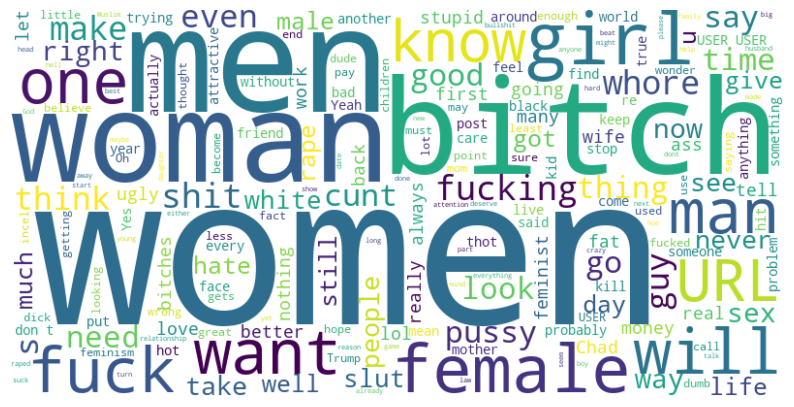

In [ ]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

train_sexist = pd.read_csv("train_sexist.csv")

text_combined = ' '.join(train_sexist['text'])

wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(text_combined)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [ ]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import numpy as np
from transformers import BertTokenizer, BertModel
import torch

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

train_sexist = pd.read_csv("train_sexist.csv")

embeddings = []
texts = train_sexist['text'].tolist()
for text in texts:
    input_ids = tokenizer.encode(text, add_special_tokens=True, max_length=512, truncation=True, return_tensors='pt')
    with torch.no_grad():
        outputs = model(input_ids)
    last_hidden_state = outputs.last_hidden_state
    mean_embedding = torch.mean(last_hidden_state, dim=1).squeeze().numpy()  # Mean pooling over token embeddings
    embeddings.append(mean_embedding)

embeddings = np.array(embeddings)

kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(embeddings)

pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

plt.figure(figsize=(12, 8))
for i, (x, y) in enumerate(embeddings_2d):
    plt.scatter(x, y, c=kmeans.labels_[i], cmap='viridis', alpha=0.5)
    plt.text(x, y, texts[i], fontsize=8, ha='center', va='center', wrap=True)

plt.title('2D Visualization of Sexist Words')

plt.colorbar(label='Cluster')
plt.show()


/Library/Python/3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/sanya/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128580 (\N{FACE WITH ROLLING EYES}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/sanya/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129315 (\N{ROLLING ON THE FLOOR LAUGHING}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/sanya/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128405 (\N{REVERSED HAND WITH MIDDLE FINGER EXTENDED}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/sanya/Library/Python/3.9/lib/python/site-packages/IPython/core

ValueError: 
Like us - But we do not want Stuff that is Broken adn Spoiled beyond repar with baggage - A Pu$$
                                                                                              ^
ParseException: Expected end of text, found '$'  (at char 94), (line:1, col:95)

<Figure size 1200x800 with 2 Axes>

### lexicon construction

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/sanya/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/sanya/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/sanya/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/sanya/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

stoplist = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

In [ ]:
import string

def preprocess(sent, lemma=True):
  sent = sent.lower()
  words = nltk.word_tokenize(sent)

  words = [w for w in words if w not in stoplist]

  words = [w for w in words if w not in string.punctuation]

  return words

In [ ]:
import pandas as pd
from collections import Counter
target_column = "label_category"
if target_column == "label_category":
  label_values = [
      '1. threats, plans to harm and incitement',
      '2. derogation',
      '3. animosity',
      '4. prejudiced discussions',
  ]

elif target_column == "label_vector":
  label_values = [
      '1.1 threats of harm',
      '1.2 incitement and encouragement of harm',
      '2.1 descriptive attacks',
      '2.2 aggressive and emotive attacks',
      '2.3 dehumanising attacks & overt sexual objectification',
      '3.1 casual use of gendered slurs, profanities, and insults',
      '3.2 immutable gender differences and gender stereotypes',
      '3.3 backhanded gendered compliments',
      '3.4 condescending explanations or unwelcome advice',
      '4.1 supporting mistreatment of individual women',
      '4.2 supporting systemic discrimination against women as a group',
  ]

In [ ]:
from collections import Counter

def get_counters(words, labels):
  Cx = Counter()
  Cy = Counter()
  Cxy = Counter()

  for sent in words:
    Cx.update(sent)

  for idx, sent in enumerate(words):
    for w in sent:
      Cxy[(labels[idx], w)] += 1

  Cy.update(labels)

  return Cx, Cy, Cxy

In [ ]:
import math

def get_PMI(label_values, Cx, Cy, Cxy):
  vocabs = Cx.keys()
  Nx = sum(Cx.values())
  Ny = sum(Cy.values())
  N = Nx + Ny

  PMI = {}
  for label in label_values:
    PMI[label] = {}

  for label in label_values:
    Py = Cy[label]/N
    for w in vocabs:
      Px = Cx[w]/N
      Pxy = Cxy[(label, w)]/N

      delta = 1e-10
      PMI[label][w] = max(math.log2((Pxy+delta)/(Px*Py)), 0)
  return PMI

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


def select_lexicons(label_values, vocabs, PMI, q=0.9):
  lexicons = {}
  for label in label_values:
    lexicons[label] = {}

    pmi_values = PMI[label].values()

    pmi_values = [p for p in pmi_values if p > 0]
    threshold = np.quantile(pmi_values, q)
    for w in vocabs:
      if PMI[label][w] >= threshold:
        lexicons[label][w] = PMI[label][w]
  return lexicons

In [ ]:
from sklearn.metrics import f1_score

def predict(word, lexicons):
  cnt = {}
  for label in label_values:
    cnt[label] = 0

  for w in word:
    for label in label_values:
      if w in lexicons[label]:
        cnt[label] += lexicons[label][w]


  if sum(cnt.values())==0:
    return None

  return max(cnt.items(), key=lambda k: k[1])[0]

# lexicons = select_lexicons(label_values, vocabs, PMI, q=0.75)

def run_predict(test_words, test_labels, lexicons, return_predict=False):
  y_pred = []
  y_test = []
  non = 0
  for word, label in zip(test_words, test_labels):
    pred = predict(word, lexicons)
    if pred is None:
      non += 1
      continue

    y_pred.append(pred)
    y_test.append(label)

  f1 = f1_score(y_test, y_pred, average='macro')
  skip = non/len(test_words)

  if return_predict:
    return f1, skip, y_test, y_pred

  # print("F1:", f1)
  # print("Skip:", skip)
  return f1, skip

In [ ]:
all_f1, all_skip = {}, {}
for q in np.arange(0.5, 1, 0.05):
  all_f1[q] = []
  all_skip[q] = []

In [ ]:
for i in range(5):
  train = pd.read_csv(f"train_sexist.csv")
  val = pd.read_csv(f"dev_sexist.csv")
  # test = pd.read_csv(f"test_sexist.csv")

  texts = train["text"].values
  train_words = [preprocess(s, lemma=True) for s in texts]
  train_labels = train[target_column].values

  texts = val["text"].values
  val_words = [preprocess(s, lemma=True) for s in texts]
  val_labels = val[target_column].values

  # texts = test["text"].values
  # test_words = [preprocess(s, lemma=True) for s in texts]
  # test_labels = test[target_column].values


  Cx, Cy, Cxy = get_counters(train_words, train_labels)
  vocabs = Cx.keys()

  PMI = get_PMI(label_values, Cx, Cy, Cxy)


  for q in np.arange(0.5, 1, 0.05):
    lexicons = select_lexicons(label_values, vocabs, PMI, q=q)
    f1, skip = run_predict(val_words, val_labels, lexicons)

    all_f1[q].append(f1)
    all_skip[q].append(skip)

  # print("DONE",i)

DONE 0
DONE 1
DONE 2
DONE 3
DONE 4


In [ ]:
# import numpy as np

# for q in np.arange(0.5, 1, 0.05):
#   print(f"{q:.3f} >> F1:{np.mean(all_f1[q]):.3f}±{np.std(all_f1[q]):.3f}, SKIP: {np.mean(all_skip[q]):.3f}±{np.std(all_skip[q]):.3f}")

In [ ]:

data = pd.read_csv("train_sexist.csv")
# data = data[data[target_column]!="none"]

texts = data["text"].values
words = [preprocess(s, lemma=True) for s in texts]
labels = data[target_column].values
Cx, Cy, Cxy = get_counters(words, labels)
vocabs = Cx.keys()

PMI = get_PMI(label_values, Cx, Cy, Cxy)


lexicons = select_lexicons(label_values, vocabs, PMI, q=0.90)

In [ ]:

for c in lexicons:
  lexicons[c] = {k: v for k, v in sorted(lexicons[c].items(), key=lambda item: -item[1])}

  print(c, len(lexicons[c]), list(lexicons[c].keys()))

1. threats, plans to harm and incitement 484 ['escalating', 'j00s', 'cuckolded', 'exception', "'right", 'porks', 'tough', 'accompany', 'implication', 'excusable', 'smelt', 'bratty', 'continuing', 'genital', 'warts', 'interpretation', 'hb10', 'reins', 'befall', 'conflict', 'negligent', 'shithead', 'ray', 'minced', 'suitcase', 'slams', 'headfirst', 'lockherup', '~~fortunate~~', 'unfortunate', 'heel', 'measly', 'push-pull', 'gunned', 'nine', 'mm', 'silencing', 'stoopid', 'jewshit-babbling', 'porterhouse', 'steak', 'loin', 'greasy', 'turkey', 'funeral', 'execute', 'wwg1wga', 'uniteamerica', 'voterepublican', 'saveamerica', 'thegreatawakening', 'thepain', 'crowder', 'lovin', 'blows', 'mollie', 'grounded', 'patriarch', 'molly', 'tibbets', 'immigrants', 'toilets', 'masturbate', 'loudly', 'breathing', 'mic', 'banned', 'repeatedly', 'pleadings', '~~if~~', 'do.-says', 'officer', 'translation', 'assaulting/harassing', 'sexiest', 'tucked', '£20', 'leotard', 'beloved', 'refugees', '1vs1', 'mw2', 'r

In [ ]:

import json
with open('lexicons.json', 'w') as outfile:
    json.dump(lexicons, outfile)

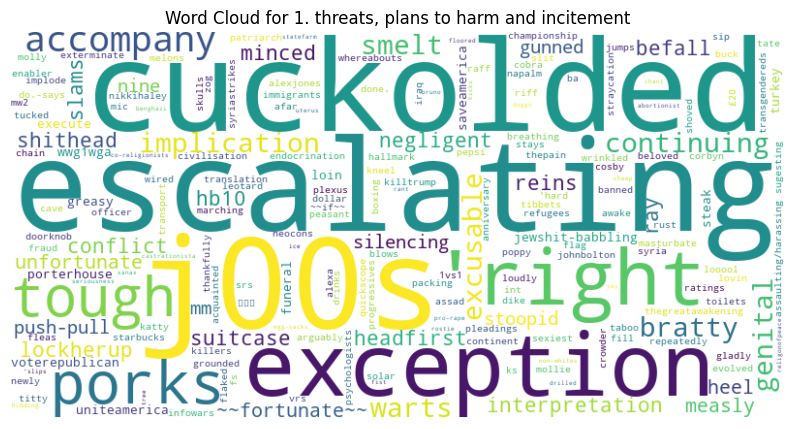

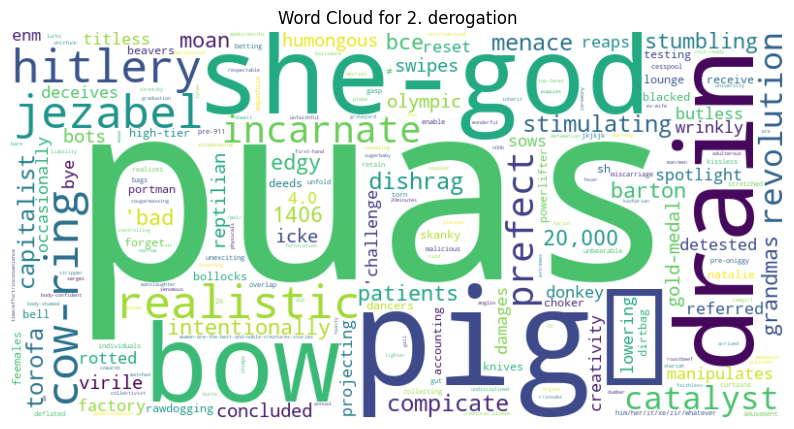

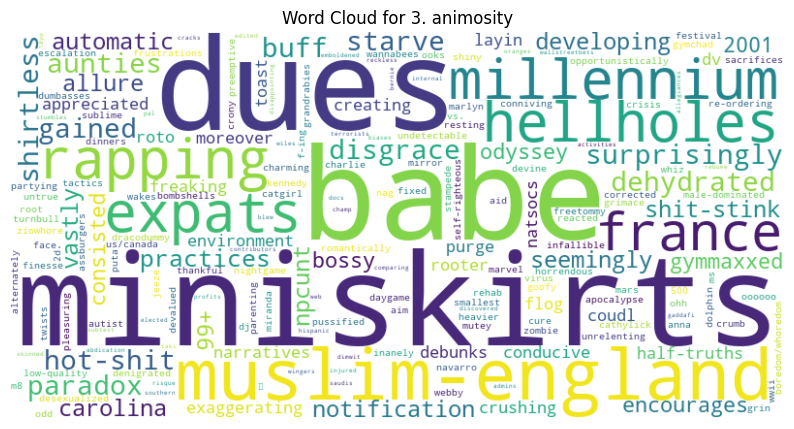

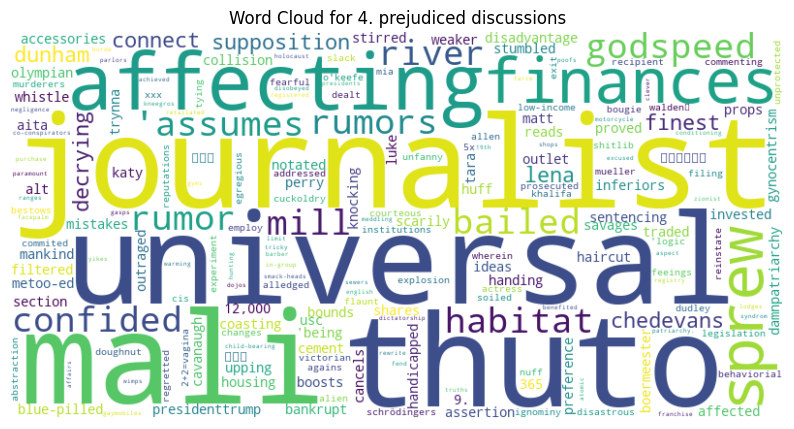

In [ ]:
import json
from wordcloud import WordCloud
import matplotlib.pyplot as plt

with open("lexicons.json", "r") as file:
    lexicons = json.load(file)

def generate_wordcloud(category):
    words_with_scores = lexicons.get(category, {})
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(words_with_scores)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title('Word Cloud for ' + category)
    plt.axis('off')
    plt.show()

categories = ['1. threats, plans to harm and incitement',
              '2. derogation',
              '3. animosity',
              '4. prejudiced discussions']

for category in categories:
    generate_wordcloud(category)


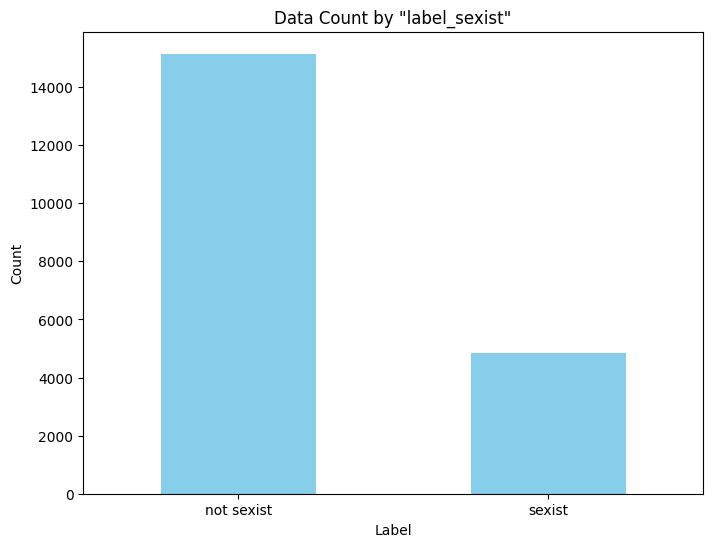

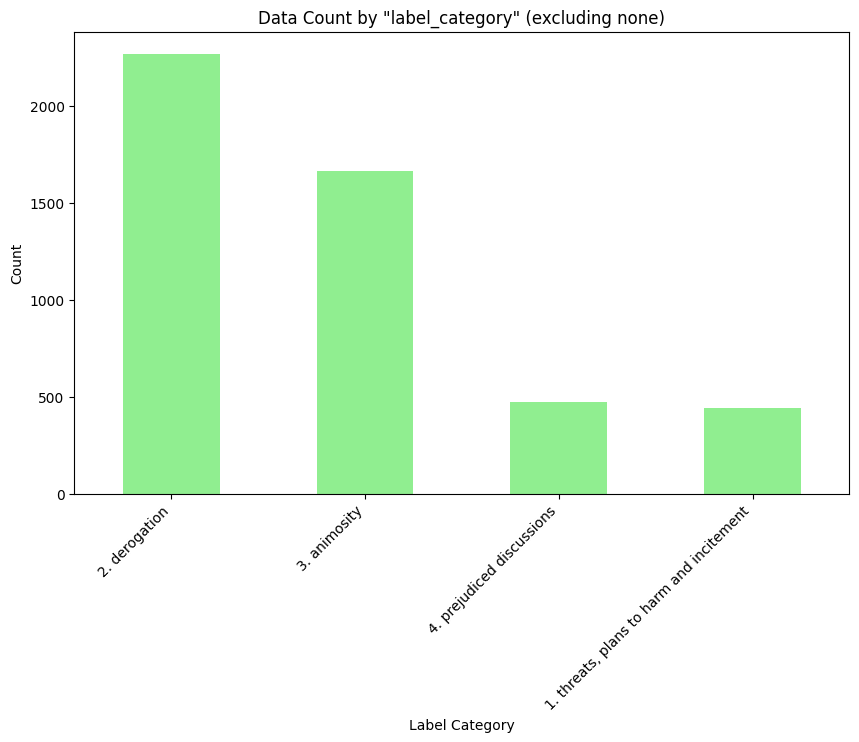

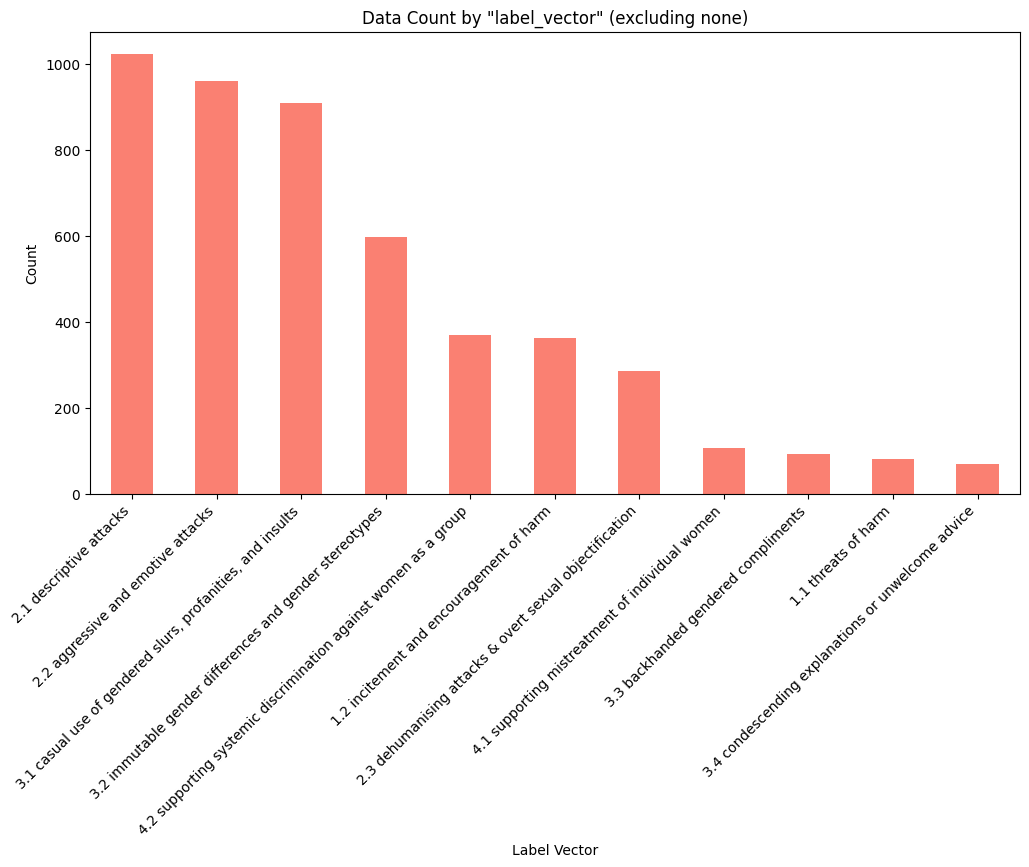

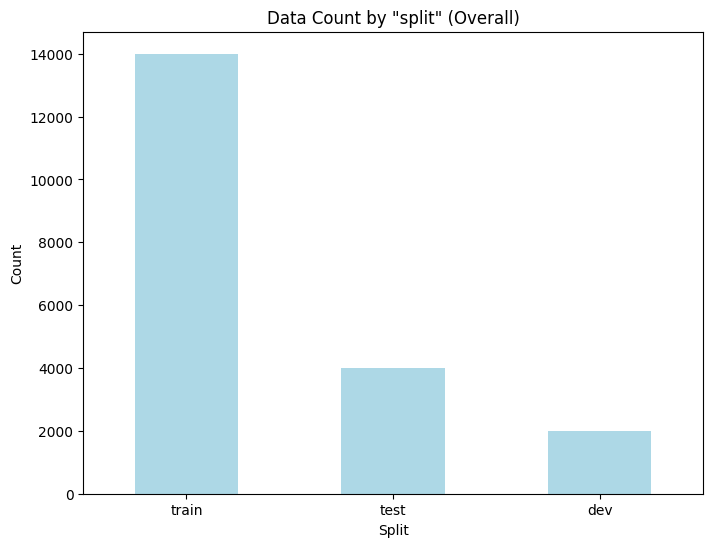

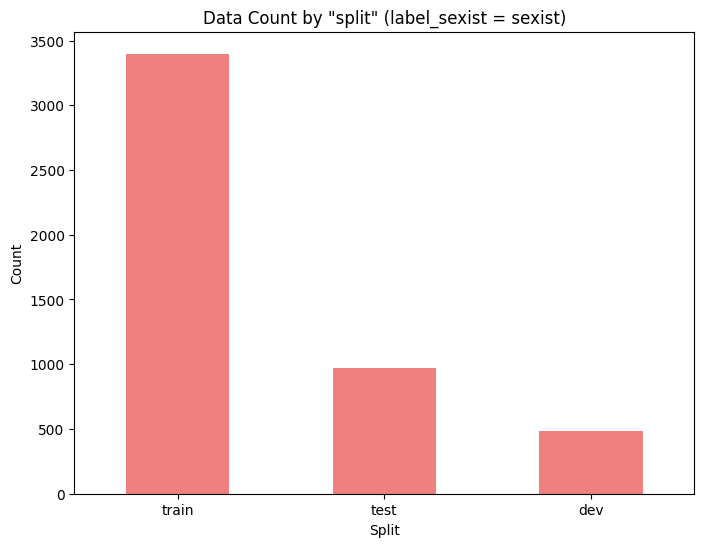

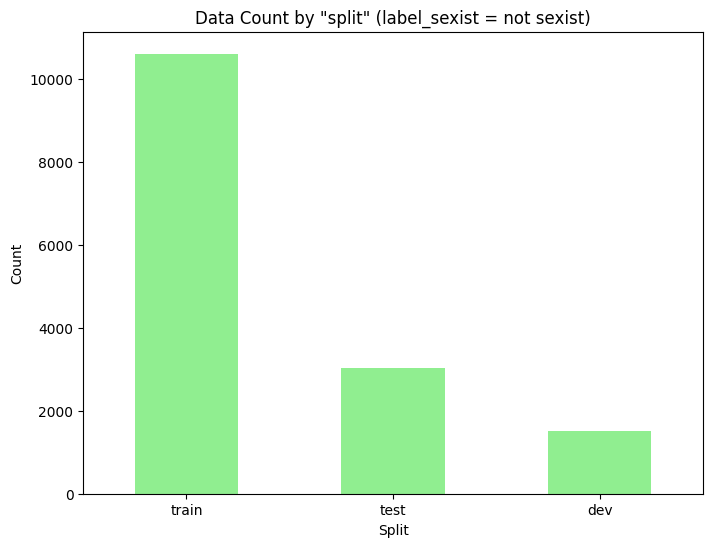

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("edos_data.csv")

plt.figure(figsize=(8, 6))
df['label_sexist'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Data Count by "label_sexist"')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

plt.figure(figsize=(10, 6))
df[df['label_category'] != 'none']['label_category'].value_counts().plot(kind='bar', color='lightgreen')
plt.title('Data Count by "label_category" (excluding none)')
plt.xlabel('Label Category')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

plt.figure(figsize=(12, 6))
df[df['label_vector'] != 'none']['label_vector'].value_counts().plot(kind='bar', color='salmon')
plt.title('Data Count by "label_vector" (excluding none)')
plt.xlabel('Label Vector')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

plt.figure(figsize=(8, 6))
df['split'].value_counts().plot(kind='bar', color='lightblue')
plt.title('Data Count by "split" (Overall)')
plt.xlabel('Split')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

plt.figure(figsize=(8, 6))
df[df['label_sexist'] == 'sexist']['split'].value_counts().plot(kind='bar', color='lightcoral')
plt.title('Data Count by "split" (label_sexist = sexist)')
plt.xlabel('Split')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

# Histogram 4c: Data count on the basis of "split" when label_sexist = not sexist
plt.figure(figsize=(8, 6))
df[df['label_sexist'] == 'not sexist']['split'].value_counts().plot(kind='bar', color='lightgreen')
plt.title('Data Count by "split" (label_sexist = not sexist)')
plt.xlabel('Split')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()


In [ ]:
from collections import Counter
import math
import numpy as np
from sklearn.metrics import f1_score

def get_counters_for_text(text, label):
    Cx = Counter(text)
    Cy = Counter([label])
    Cxy = Counter([(label, w) for w in text])
    return Cx, Cy, Cxy

def get_PMI_for_text(text, label, vocabs, Cx, Cy, Cxy):
    Nx = sum(Cx.values())
    Ny = sum(Cy.values())
    N = Nx + Ny

    PMI = {}

    Py = Cy[label]/N
    for w in vocabs:
        Px = Cx[w]/N
        Pxy = Cxy[(label, w)]/N

        delta = 1e-10
        PMI[w] = max(math.log2((Pxy+delta)/(Px*Py)), 0)
    return PMI

def select_lexicons_for_text(vocabs, PMI, threshold):
    lexicons = {}
    pmi_values = PMI.values()
    pmi_values = [p for p in pmi_values if p > 0]
    threshold = np.quantile(pmi_values, threshold)
    for w in vocabs:
        if PMI[w] >= threshold:
            lexicons[w] = PMI[w]
    return lexicons

def predict_for_text(text, lexicons):
    cnt = 0
    for w in text:
        if w in lexicons:
            cnt += lexicons[w]
    return cnt

def run_predict_for_text(test_texts, test_labels, lexicons, return_predict=False):
    y_pred = []
    y_test = []
    non = 0
    for text, label in zip(test_texts, test_labels):
        pred = predict_for_text(text, lexicons)
        if pred == 0:
            non += 1
            continue
        y_pred.append(pred)
        y_test.append(label)

    f1 = f1_score(y_test, y_pred, average='macro')
    skip = non / len(test_texts)

    if return_predict:
        return f1, skip, y_test, y_pred
    return f1, skip

all_f1, all_skip = {}, {}
for q in np.arange(0.5, 1, 0.05):
    all_f1[q] = []
    all_skip[q] = []

for i in range(5):
    train = pd.read_csv(f"train_sexist.csv")
    val = pd.read_csv(f"dev_sexist.csv")

    train_texts = train["text"].values
    train_labels = train["label_category"].values

    val_texts = val["text"].values
    val_labels = val["label_category"].values

    for q in np.arange(0.5, 1, 0.05):
        f1, skip = 0, 0

        for text, label in zip(train_texts, train_labels):
            Cx, Cy, Cxy = get_counters_for_text(text, label)
            vocabs = Cx.keys()
            PMI = get_PMI_for_text(text, label, vocabs, Cx, Cy, Cxy)
            lexicons = select_lexicons_for_text(vocabs, PMI, q=q)
            f1, skip = run_predict_for_text(val_texts, val_labels, lexicons)
            all_f1[q].append(f1)
            all_skip[q].append(skip)

    print("DONE", i)

print("Lexicon generation and evaluation completed.")


In [ ]:
import json

with open("lexicons.json", "r") as file:
    lexicons = json.load(file)

text = train_texts[5]

text_tokens = preprocess(text, lemma=True)

text_lexicons = {}
for category, category_lexicons in lexicons.items():
    text_lexicons[category] = {}
    for word, score in category_lexicons.items():
        if word in text_tokens:
            text_lexicons[category][word] = score

for category, category_lexicons in text_lexicons.items():
    print(f"Lexicons for category '{category}':")
    for word, score in category_lexicons.items():
        print(f"Word: {word}, Score: {score}")
    print()


Lexicons for category '1. threats, plans to harm and incitement':

Lexicons for category '2. derogation':

Lexicons for category '3. animosity':

Lexicons for category '4. prejudiced discussions':
Word: godspeed, Score: 7.272997913107311



In [ ]:
import pandas as pd
import json

with open("lexicons.json", "r") as file:
    lexicons = json.load(file)

df = pd.read_csv("train_sexist.csv")

def mask_text(text, lexicons):
    text_tokens = preprocess(text, lemma=True)
    for category_lexicons in lexicons.values():
        for word, score in category_lexicons.items():
            if word in text_tokens:
                text = text.replace(word, "[MASK]")
    return text

df['text_masked'] = df['text'].apply(lambda x: mask_text(x, lexicons))

df.to_csv("train_sexist_masked.csv", index=False)


In [ ]:
df = pd.read_csv("test_sexist.csv")

def mask_text(text, lexicons):
    text_tokens = preprocess(text, lemma=True)
    for category_lexicons in lexicons.values():
        for word, score in category_lexicons.items():
            if word in text_tokens:
                text = text.replace(word, "[MASK]")
    return text

df['text_masked'] = df['text'].apply(lambda x: mask_text(x, lexicons))

df.to_csv("test_sexist_masked.csv", index=False)

In [ ]:
df = pd.read_csv("dev_sexist.csv")

def mask_text(text, lexicons):
    text_tokens = preprocess(text, lemma=True)
    for category_lexicons in lexicons.values():
        for word, score in category_lexicons.items():
            if word in text_tokens:
                text = text.replace(word, "[MASK]")
    return text

df['text_masked'] = df['text'].apply(lambda x: mask_text(x, lexicons))

df.to_csv("dev_sexist_masked.csv", index=False)

In [ ]:
[USER] Leg day is easy. Hot girls who wear [MASK] get asked out.